Best parameters for car data:
n_clusters           2.000000
batch_size          64.000000
silhouette_score     0.181904
Name: 1, dtype: float64

Best parameters for customer data:
n_clusters          10.000000
batch_size          64.000000
silhouette_score     0.344245
Name: 33, dtype: float64


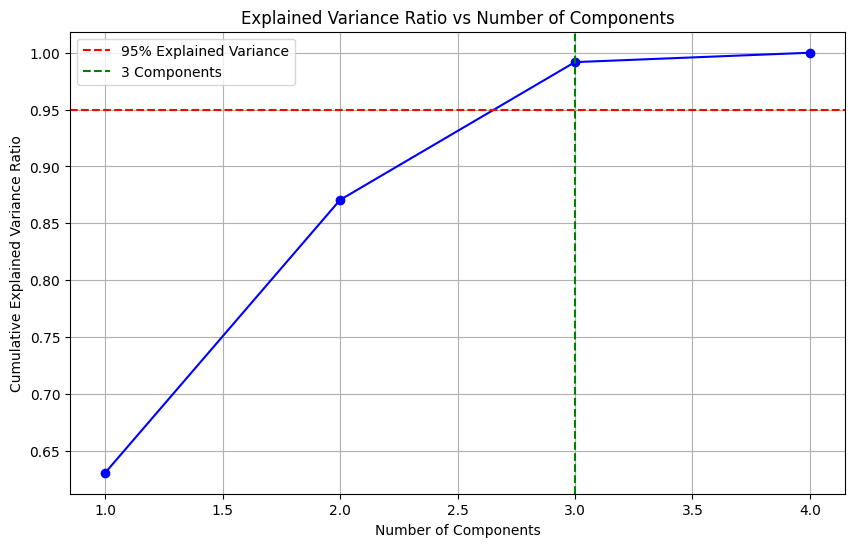

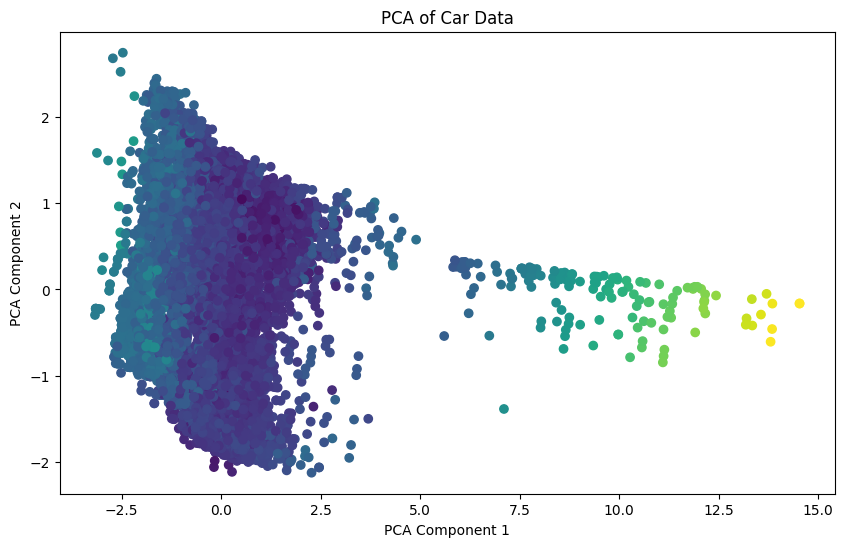

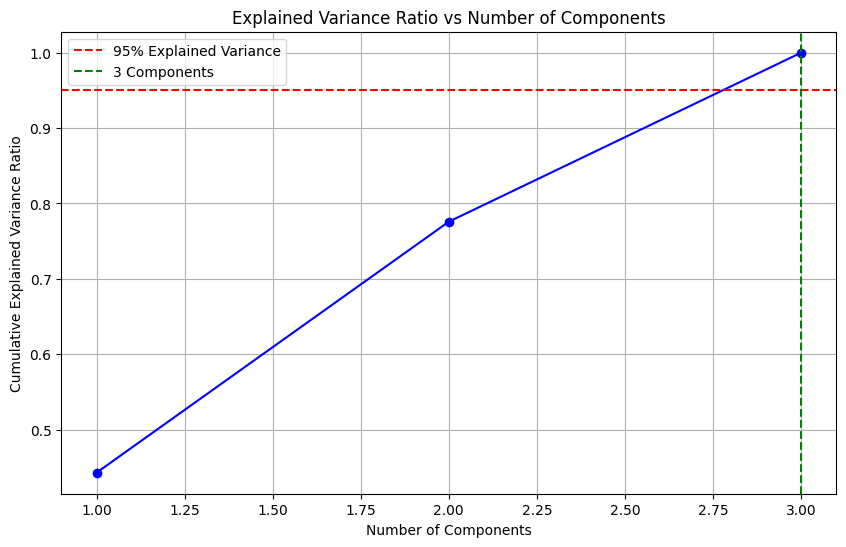

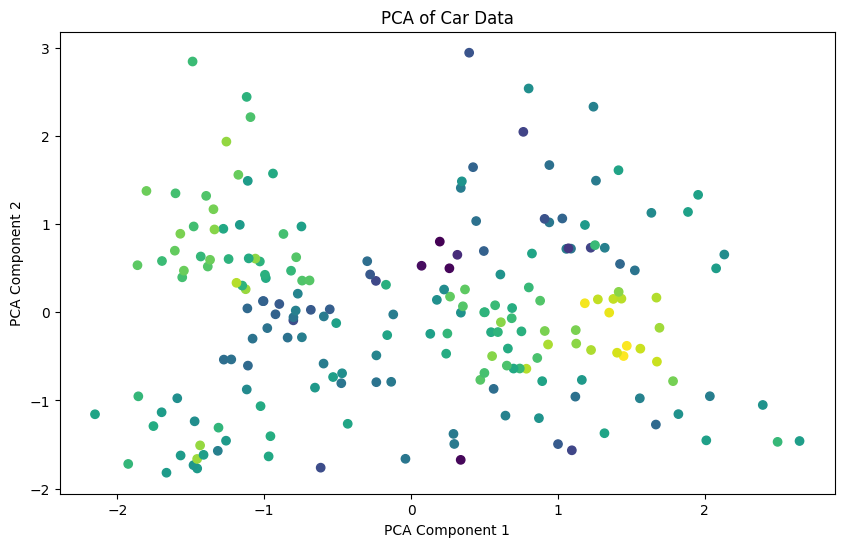

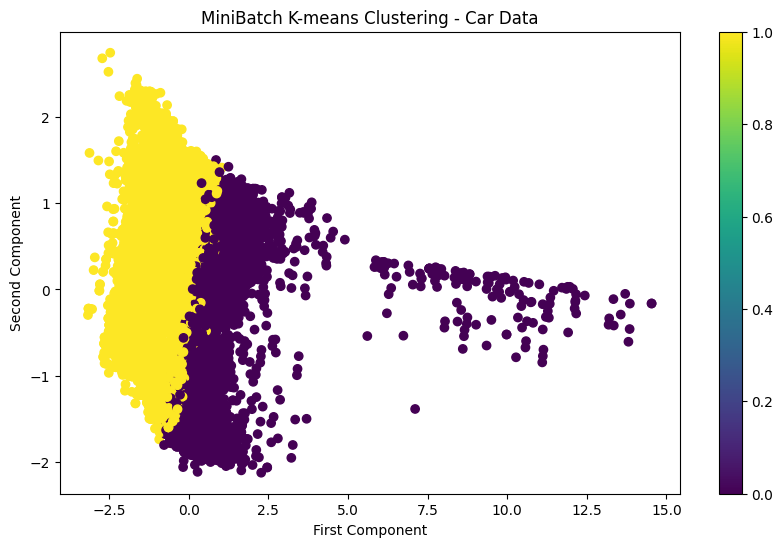

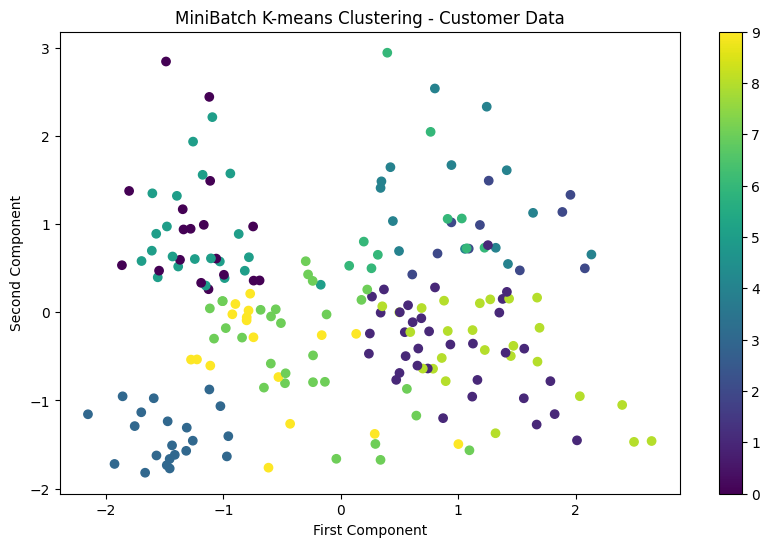

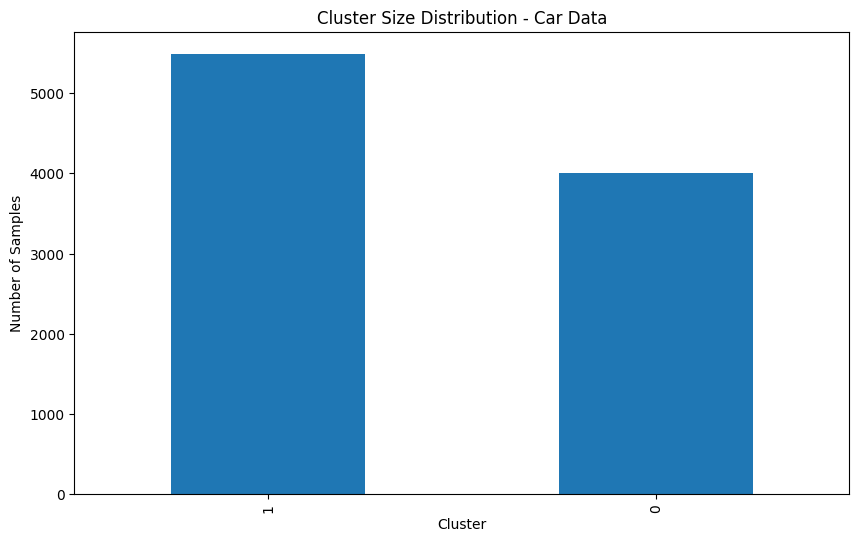


Cluster Statistics - Car Data:
                0                         1                         2  \
             mean       std count      mean       std count      mean   
Cluster                                                                 
0        1.050660  1.810315  4011 -0.362505  0.956656  4011 -0.325739   
1       -0.767055  0.760161  5494  0.264654  0.909246  5494  0.237812   

                               0  ...    97        98                  \
             std count      mean  ... count      mean       std count   
Cluster                           ...                                   
0        0.72120  4011  0.000997  ...  4011  0.009723  0.098138  4011   
1        0.57002  5494  0.001092  ...  5494  0.584274  0.492892  5494   

               99                       100                  
             mean       std count      mean       std count  
Cluster                                                      
0        0.000000  0.000000  4011  0.035403  0.184

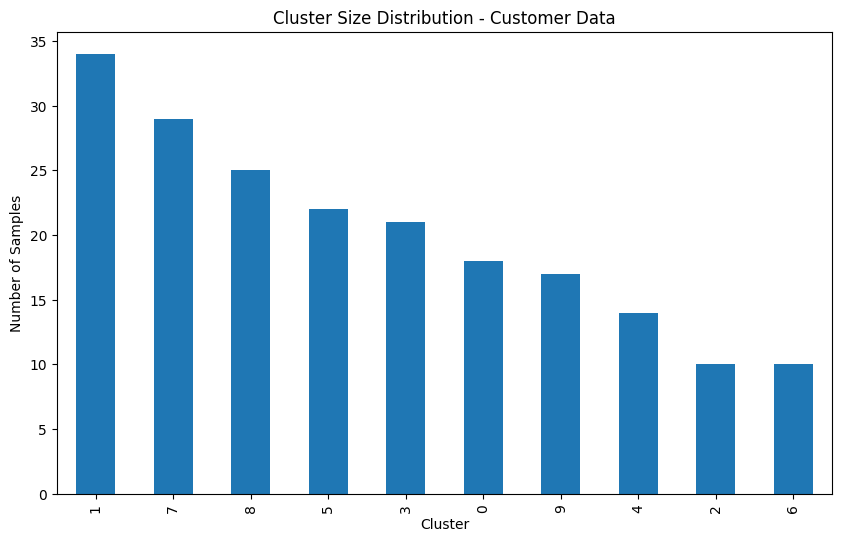


Cluster Statistics - Customer Data:
                0                         1                         2  \
             mean       std count      mean       std count      mean   
Cluster                                                                 
0       -1.221250  0.328010    18  0.952591  0.720424    18  0.613779   
1        0.938272  0.508613    34 -0.386886  0.511057    34  0.482421   
2        1.334404  0.506437    10  0.877390  0.374754    10 -0.289498   
3       -1.471247  0.312368    21 -1.406540  0.295070    21  0.104667   
4        1.000559  0.555262    14  1.301684  0.627158    14 -0.554013   
5       -1.198097  0.358996    22  0.883963  0.542716    22  0.519260   
6        0.623510  0.420745    10  1.106428  0.786105    10 -1.618810   
7       -0.304109  0.554720    29 -0.423251  0.651081    29 -0.765277   
8        1.289002  0.621156    25 -0.429740  0.517816    25  0.759402   
9       -0.568075  0.589395    17 -0.526256  0.607132    17 -0.648518   

             

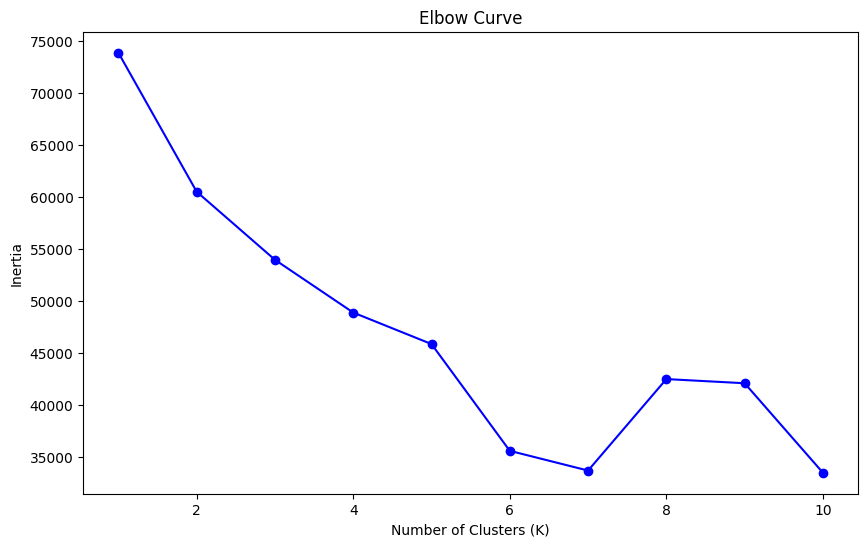

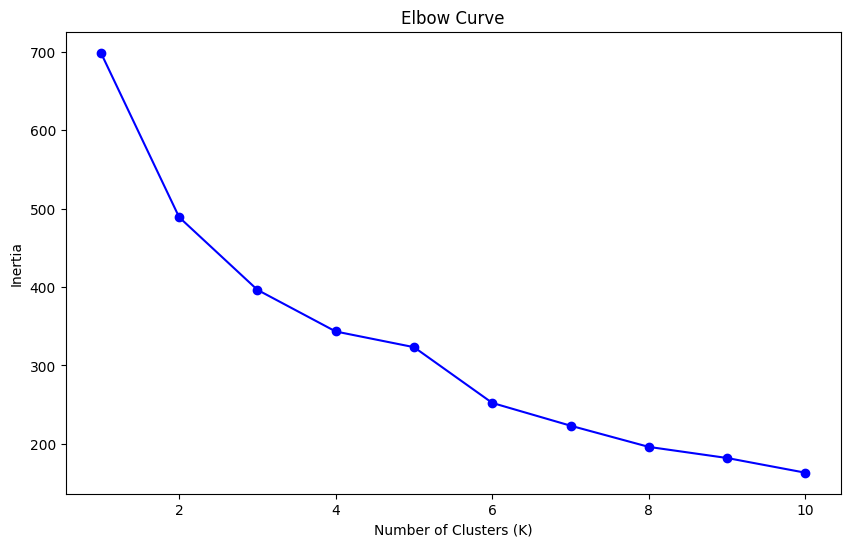

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from src.prep import Prep

np.random.seed(47)

# Load and prepare data
prep = Prep(output_pca=True)
car_data = prep.prep_car
customer_data = prep.prep_customer

def evaluate_minibatch_kmeans(data, n_clusters_range, batch_sizes, max_iter=100):
    """
    Evaluate MiniBatch K-means with different parameters using silhouette score
    """
    results = []
    
    for n_clusters in n_clusters_range:
        for batch_size in batch_sizes:
            mbk = MiniBatchKMeans(
                n_clusters=n_clusters,
                batch_size=batch_size,
                max_iter=max_iter,
                random_state=42
            )
            
            labels = mbk.fit_predict(data)
            score = silhouette_score(data, labels)
            
            results.append({
                'n_clusters': n_clusters,
                'batch_size': batch_size,
                'silhouette_score': score
            })
    
    return pd.DataFrame(results)

n_clusters_range = range(2, 11)
batch_sizes = [32, 64, 128, 256]

# Evaluate parameters for car data
car_results = evaluate_minibatch_kmeans(car_data, n_clusters_range, batch_sizes)
print("Best parameters for car data:")
print(car_results.loc[car_results['silhouette_score'].idxmax()])

# Evaluate parameters for customer data
customer_results = evaluate_minibatch_kmeans(customer_data, n_clusters_range, batch_sizes)
print("\nBest parameters for customer data:")
print(customer_results.loc[customer_results['silhouette_score'].idxmax()])

def plot_clustering_results(data, labels, title):
    """
    Visualize clustering results using first two dimensions
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'MiniBatch K-means Clustering - {title}')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.show()

# Apply best parameters to car data
best_car_params = car_results.loc[car_results['silhouette_score'].idxmax()]
mbk_car = MiniBatchKMeans(
    n_clusters=int(best_car_params['n_clusters']),
    batch_size=int(best_car_params['batch_size']),
    random_state=42
)
car_labels = mbk_car.fit_predict(car_data)

# Apply best parameters to customer data
best_customer_params = customer_results.loc[customer_results['silhouette_score'].idxmax()]
mbk_customer = MiniBatchKMeans(
    n_clusters=int(best_customer_params['n_clusters']),
    batch_size=int(best_customer_params['batch_size']),
    random_state=42
)
customer_labels = mbk_customer.fit_predict(customer_data)

# Plot results
plot_clustering_results(car_data, car_labels, 'Car Data')
plot_clustering_results(customer_data, customer_labels, 'Customer Data')

def analyze_clusters(data, labels, title):
    """
    Analyze cluster characteristics
    """
    data_with_labels = data.copy()
    data_with_labels['Cluster'] = labels
    
    cluster_sizes = data_with_labels['Cluster'].value_counts()

    plt.figure(figsize=(10, 6))
    cluster_sizes.plot(kind='bar')
    plt.title(f'Cluster Size Distribution - {title}')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')
    plt.show()
    
    cluster_stats = data_with_labels.groupby('Cluster').agg(['mean', 'std', 'count'])
    print(f"\nCluster Statistics - {title}:")
    print(cluster_stats)

# Analyze clustering results
analyze_clusters(car_data, car_labels, 'Car Data')
analyze_clusters(customer_data, customer_labels, 'Customer Data')

# Plot elbow curve for different K values
def plot_elbow_curve(data, max_k, batch_size):
    """
    Plot elbow curve to help determine optimal K
    """
    inertias = []
    k_values = range(1, max_k + 1)
    
    for k in k_values:
        mbk = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=42)
        mbk.fit(data)
        inertias.append(mbk.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertias, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Curve')
    plt.show()

# Plot elbow curves
plot_elbow_curve(car_data, 10, 64)
plot_elbow_curve(customer_data, 10, 64)


Evaluating clustering for Car Data


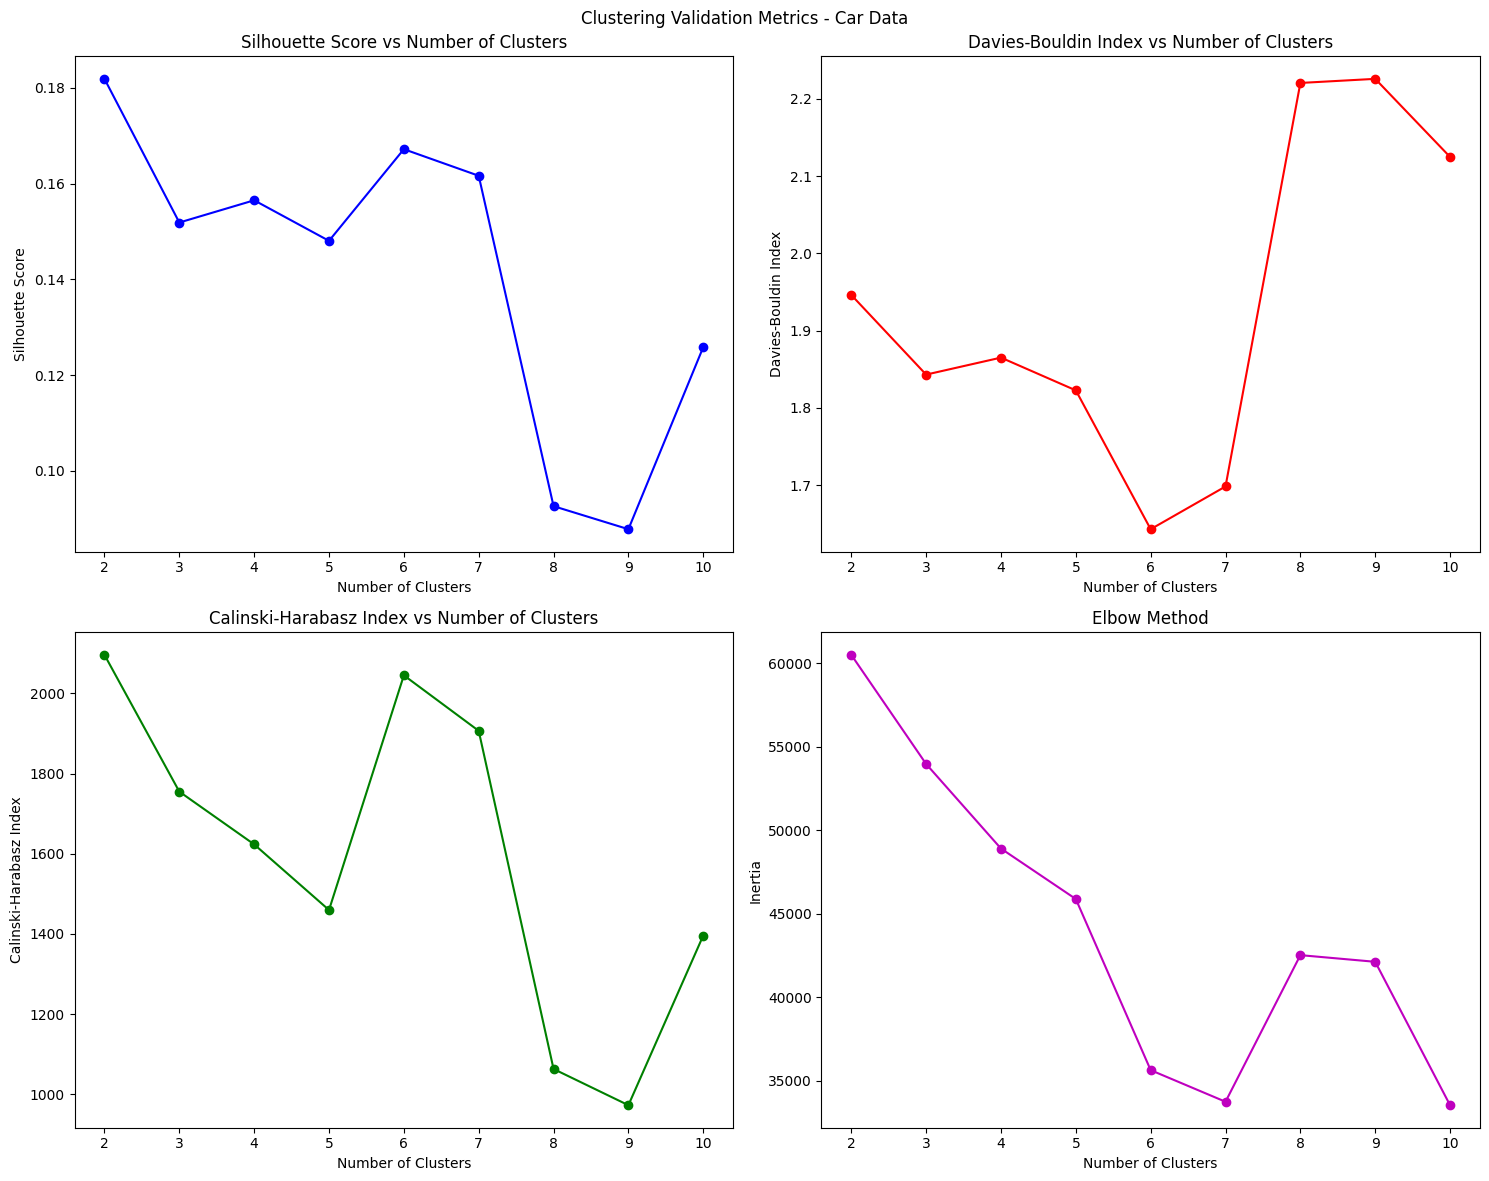


Optimal number of clusters:
Based on Silhouette Score: 2
Based on Davies-Bouldin Index: 6
Based on Calinski-Harabasz Index: 2


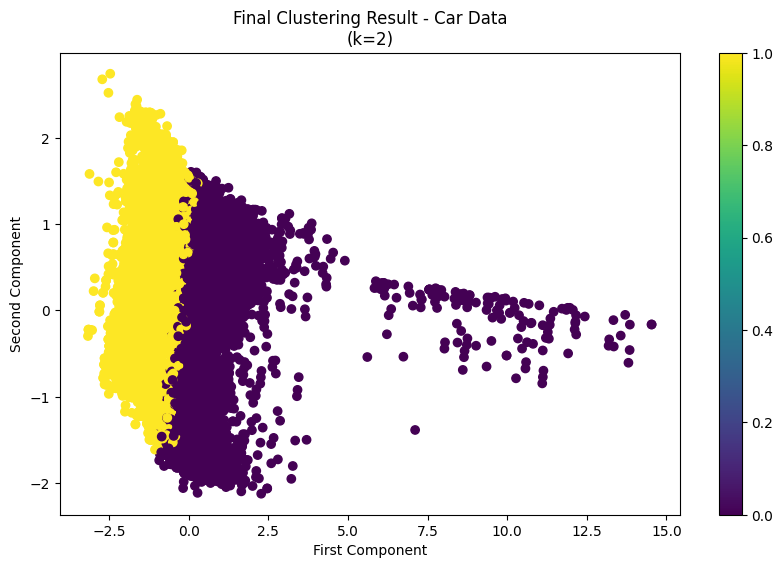


Detailed metrics for k=2:
silhouette: 0.1627
davies_bouldin: 1.9823
calinski_harabasz: 1959.8869

Evaluating clustering for Customer Data


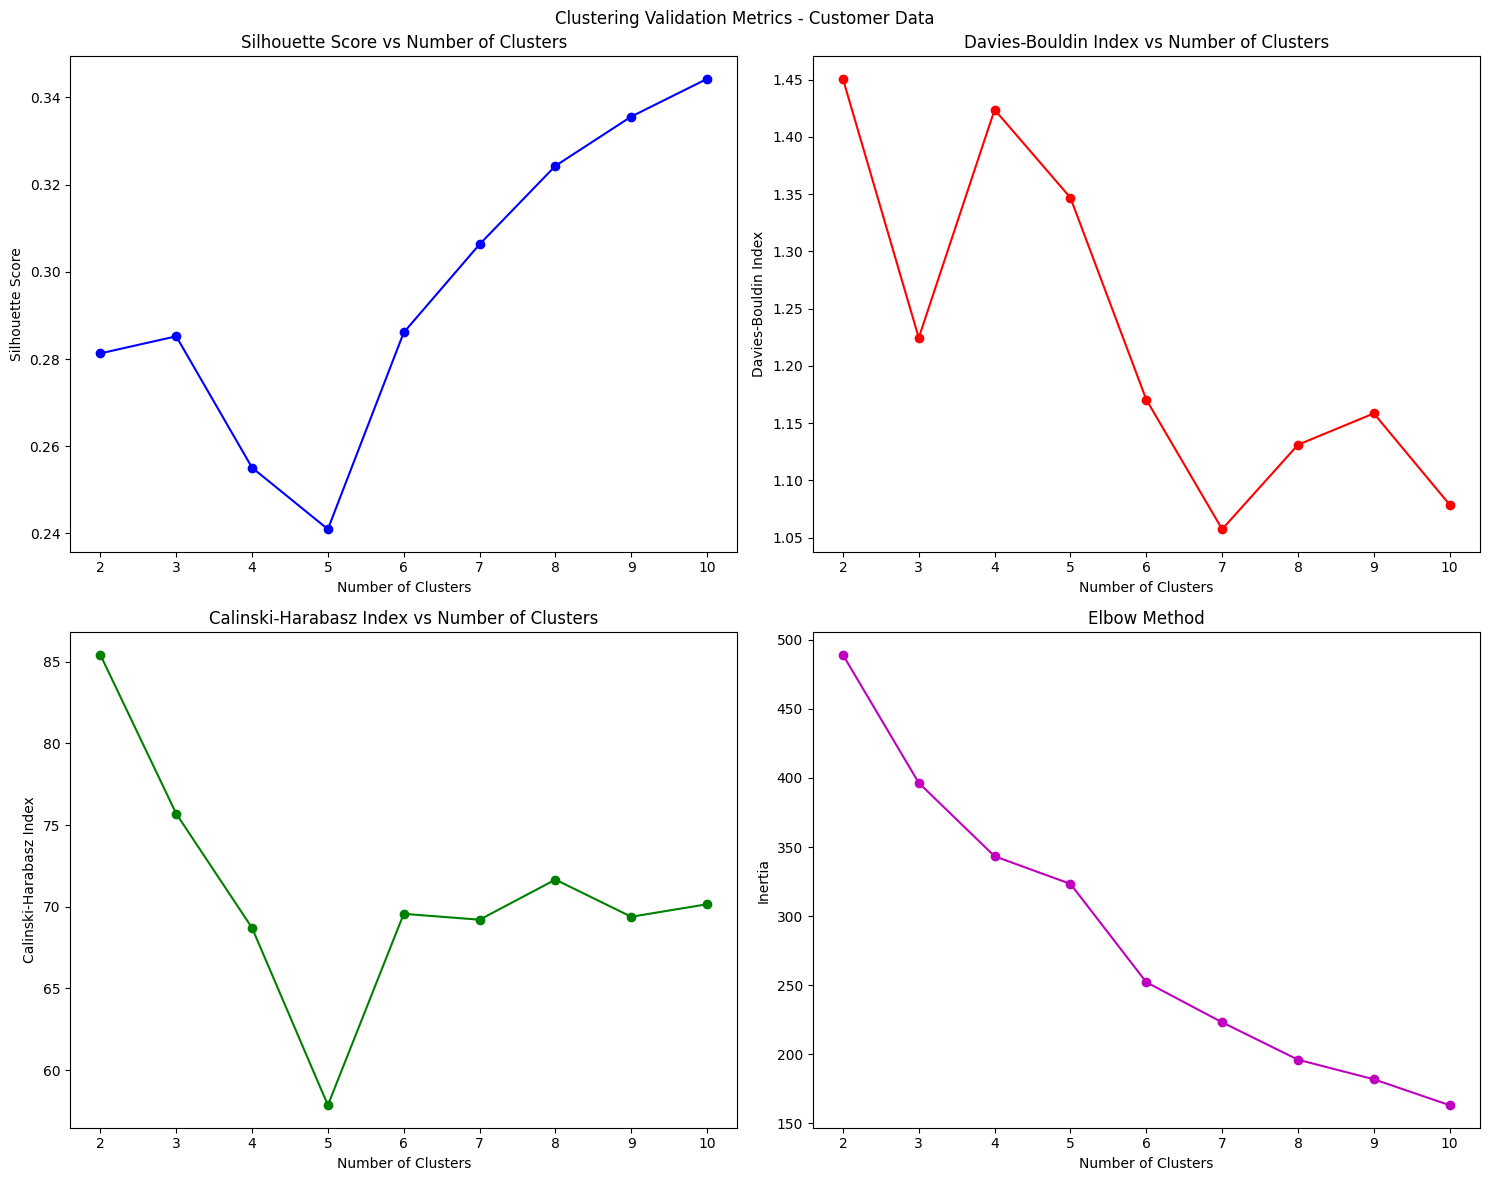


Optimal number of clusters:
Based on Silhouette Score: 10
Based on Davies-Bouldin Index: 7
Based on Calinski-Harabasz Index: 2


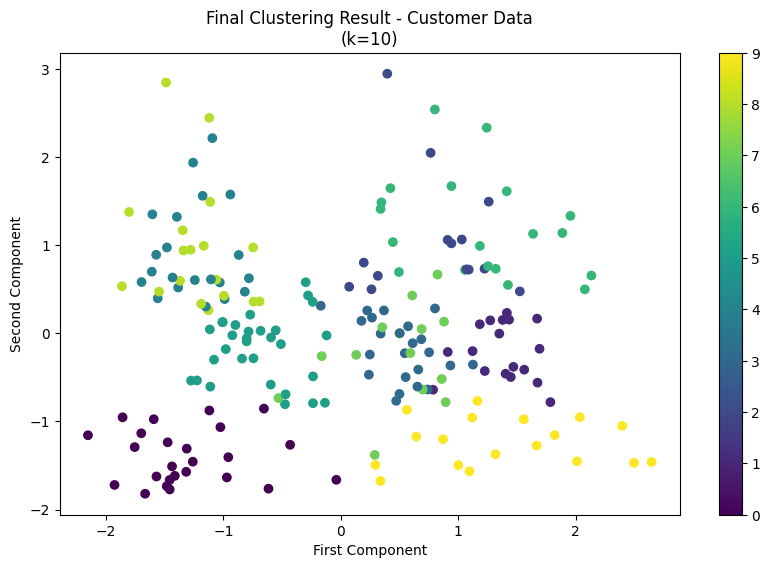


Detailed metrics for k=10:
silhouette: 0.3314
davies_bouldin: 1.0632
calinski_harabasz: 71.4106


In [9]:
def compute_validation_metrics(data, labels):
    """
    Compute multiple clustering validation metrics
    """
    metrics = {
        'silhouette': silhouette_score(data, labels),
        'davies_bouldin': davies_bouldin_score(data, labels),
        'calinski_harabasz': calinski_harabasz_score(data, labels)
    }
    return metrics

def evaluate_clustering(data, n_clusters_range, batch_size=64):
    """
    Evaluate clustering using multiple validation metrics
    """
    results = []
    
    for n_clusters in n_clusters_range:
        # Fit MiniBatch K-means
        mbk = MiniBatchKMeans(
            n_clusters=n_clusters,
            batch_size=batch_size,
            random_state=42
        )
        labels = mbk.fit_predict(data)
        
        # Calculate validation metrics
        metrics = compute_validation_metrics(data, labels)
        metrics['n_clusters'] = n_clusters
        metrics['inertia'] = mbk.inertia_
        
        results.append(metrics)
    
    return pd.DataFrame(results)

def plot_validation_metrics(results, title):
    """
    Plot all validation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Clustering Validation Metrics - {title}')
    
    # Silhouette Score (higher is better)
    axes[0, 0].plot(results['n_clusters'], results['silhouette'], 'bo-')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].set_title('Silhouette Score vs Number of Clusters')
    
    # Davies-Bouldin Index (lower is better)
    axes[0, 1].plot(results['n_clusters'], results['davies_bouldin'], 'ro-')
    axes[0, 1].set_xlabel('Number of Clusters')
    axes[0, 1].set_ylabel('Davies-Bouldin Index')
    axes[0, 1].set_title('Davies-Bouldin Index vs Number of Clusters')
    
    # Calinski-Harabasz Index (higher is better)
    axes[1, 0].plot(results['n_clusters'], results['calinski_harabasz'], 'go-')
    axes[1, 0].set_xlabel('Number of Clusters')
    axes[1, 0].set_ylabel('Calinski-Harabasz Index')
    axes[1, 0].set_title('Calinski-Harabasz Index vs Number of Clusters')
    
    # Elbow Method
    axes[1, 1].plot(results['n_clusters'], results['inertia'], 'mo-')
    axes[1, 1].set_xlabel('Number of Clusters')
    axes[1, 1].set_ylabel('Inertia')
    axes[1, 1].set_title('Elbow Method')
    
    plt.tight_layout()
    plt.show()

# Evaluate clustering for both datasets
n_clusters_range = range(2, 11)
datasets = {
    'Car Data': car_data,
    'Customer Data': customer_data
}

for name, data in datasets.items():
    print(f"\nEvaluating clustering for {name}")
    
    # Compute and plot validation metrics
    results = evaluate_clustering(data, n_clusters_range)
    plot_validation_metrics(results, name)
    
    # Find optimal number of clusters based on different metrics
    best_silhouette = results.loc[results['silhouette'].idxmax()]
    best_davies_bouldin = results.loc[results['davies_bouldin'].idxmin()]
    best_calinski = results.loc[results['calinski_harabasz'].idxmax()]
    
    print("\nOptimal number of clusters:")
    print(f"Based on Silhouette Score: {int(best_silhouette['n_clusters'])}")
    print(f"Based on Davies-Bouldin Index: {int(best_davies_bouldin['n_clusters'])}")
    print(f"Based on Calinski-Harabasz Index: {int(best_calinski['n_clusters'])}")

    # Plot final clustering with optimal k (using silhouette score)
    optimal_k = int(best_silhouette['n_clusters'])
    mbk = MiniBatchKMeans(n_clusters=optimal_k, random_state=42)
    labels = mbk.fit_predict(data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='viridis')
    plt.title(f'Final Clustering Result - {name}\n(k={optimal_k})')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.colorbar()
    plt.show()

    # Print detailed metrics for optimal k
    print(f"\nDetailed metrics for k={optimal_k}:")
    final_metrics = compute_validation_metrics(data, labels)
    for metric_name, value in final_metrics.items():
        print(f"{metric_name}: {value:.4f}")